In [8]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os

# Self-written modules
from yq.scripts import models
from yq.scripts import heston_func
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from sc import constants as cs
from sy.variance_reduction import apply_control_variates
from sy.interest_rate import populate_bond_table, get_period
from sy.calibration import apply_empirical_martingale_correction
from sc import payoff as po

In [9]:
print(cs.ASSET_NAMES)

['LONN.SE', 'SIKA.SE']


# Fetch stock data

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-10-17,357.299988,222.199997
2023-10-18,344.700012,216.300003
2023-10-19,342.000000,218.199997
2023-10-20,332.899994,217.000000
2023-10-23,327.600006,215.899994
2023-10-24,330.899994,215.699997
2023-10-25,315.000000,212.000000
2023-10-26,315.899994,211.199997
2023-10-27,314.600006,214.100006


331.3999938964844

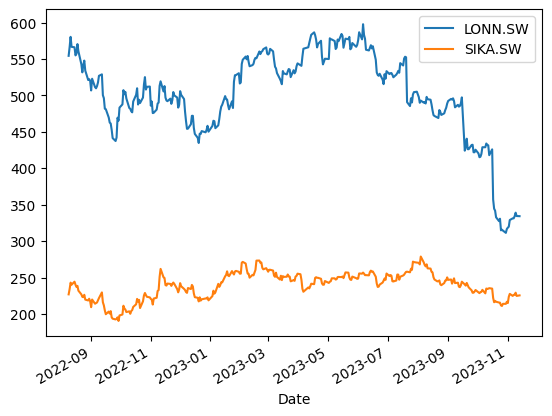

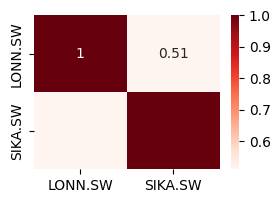

In [10]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()
display(data.loc['2023-11-07']['LONN.SW'])

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [11]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
gbm = models.PricingModel(params = params)

### Test out get sim_data list

In [ ]:
# Copy the start_time_str from the folders
product_est_date_sim_data_df_list = sm.read_sim_data(
        model_name='gbm',
        start_time_str='20231111_185351_394318', 
        prod_est_start_date=pd.Timestamp('2023-08-09'), 
        prod_est_end_date=pd.Timestamp('2023-08-10'))
print(type(product_est_date_sim_data_df_list)[0])
n_sim_on_day = pd.concat(product_est_date_sim_data_df_list[0], axis=1)
ax = n_sim_on_day.plot(alpha=0.6, legend=False)
ax.figure.show()


In [ ]:
product_est_date_sim_data_df_list[0]


# Testing diff h (stale, refer to normal sims while creating class)

In [ ]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            sim_data_h = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[1000, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")


In [ ]:
print(489/1489)


In [ ]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
heston = models.PricingModel(params = params)

In [ ]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-11-06', '2023-11-06')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = heston.multi_asset_heston_model(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            # sim_data_h = heston.multi_asset_heston_model(
            #     sim_start_date=sim_start_date, 
            #     hist_window=252, 
            #     sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
            #     h_adjustment=[1, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        # S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        # S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        # print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiHeston has error.")


In [ ]:
489/490


In [ ]:
display(sim_data)
display(sim_data_h)

In [ ]:
print(355/1404.907)

In [ ]:
0.32840832773673606

# Normal sims 

In [ ]:
trading_calendar = calendar.SIXTradingCalendar()
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-11-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 100

for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()
        params = {
            'data': data,
            'ticker_list': ['LONN.SW', 'SIKA.SW']
        }
        sim_data_df = []
        gbm = models.PricingModel(params=params)
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])
            sim_data_df.append(sim_data)
            
            sm.store_sim_data(start_time_acc=start_time_acc,
                           model_name='gbm',
                           sim_data=sim_data,
                           product_est_date=product_est_date,
                           sim=sim)

        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?

# sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data


In [12]:
# generate bond table
path = '../data/bond'

bond_yield = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':file.split(' ')[1]}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bond_yield is None:
      bond_yield = df
   else:
      bond_yield = pd.concat([bond_yield, df], axis=1)
bond_yield = bond_yield.interpolate()
bond_yield = bond_yield.reindex(sorted(bond_yield.columns, key=lambda x: get_period(x)), axis=1) # sort index
bond_price = pd.DataFrame(index=bond_yield.index)
for col in bond_yield.columns:
    bond_price[col] = bond_yield[col].apply(lambda x: np.exp(-x*get_period(col)))
bond_price

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,1.019417,1.068939,1.138828,1.268075,1.568312,2.225541,NaN
2022-01-02,1.019417,1.066270,1.135039,1.252323,1.529590,2.225541,NaN
2022-01-03,1.017067,1.072508,1.156040,1.239862,1.529590,2.225541,4.055200
2022-01-04,1.017458,1.074297,1.131261,1.239862,1.529590,2.075081,4.297356
2022-01-05,1.018241,1.075193,1.142631,1.242965,1.529590,2.075081,4.178699
...,...,...,...,...,...,...,...
2023-11-06,0.970072,0.875903,0.760839,0.668646,0.438235,0.188247,0.070510
2023-11-07,0.970072,0.875903,0.762108,0.668646,0.438235,0.188247,0.068838
2023-11-08,0.970072,0.875903,0.776209,0.668646,0.438235,0.188247,0.072223


Total sims/length of sim_data_df for 2023-08-09 00:00:00: 100
Total days is: 1



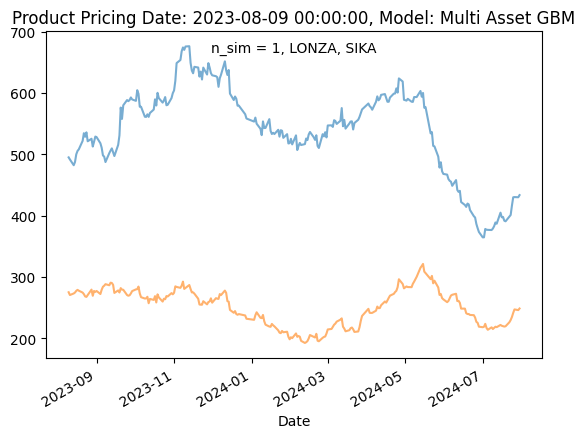

In [13]:
from yq.scripts import simulation as yqsm

# for product_est_date in bus_date_range.index:
#     try:
#         start_time = time.time()
#         params = {
#             'data': data,
#             'ticker_list': ['LONN.SW', 'SIKA.SW']
#         }
#         sim_data_df = []
#         gbm = models.PricingModel(params=params)
#         for sim in range(n_sim):
#             sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
#             sim_data = gbm.multi_asset_gbm(
#                 sim_start_date=sim_start_date, 
#                 hist_window=252, 
#                 sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
#                 h_adjustment=[0, 0])
#             sim_data_df.append(sim_data)
            
#             sm.store_sim_data(start_time_acc=start_time_acc,
#                            model_name='gbm',
#                            sim_data=sim_data,
#                            product_est_date=product_est_date,
#                            sim=sim)

        
#         print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
#     except Exception as e:
#         # Log the error with the date that caused it
#         raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?
start = pd.Timestamp('2023-08-09')
end = pd.Timestamp('2023-08-09')

product_est_date_sim_data_df_list = yqsm.read_sim_data('gbm', '20231111_195045_022812', start, end)
sim = product_est_date_sim_data_df_list[0][0]
ax = sim.plot(alpha=0.6, legend=False)
ax.set_title(f"Product Pricing Date: {start}, Model: Multi Asset GBM")
ax.text(0.5, 0.95, f"n_sim = 1, LONZA, SIKA", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()

In [ ]:
sim_interest_adjusted = gbm.adjust_interest_rate(bond_price, sim)
pd.concat([sim,sim_interest_adjusted],axis=1).plot()

In [ ]:
print(sim)
print(sim_interest_adjusted)

time difference is 272.0


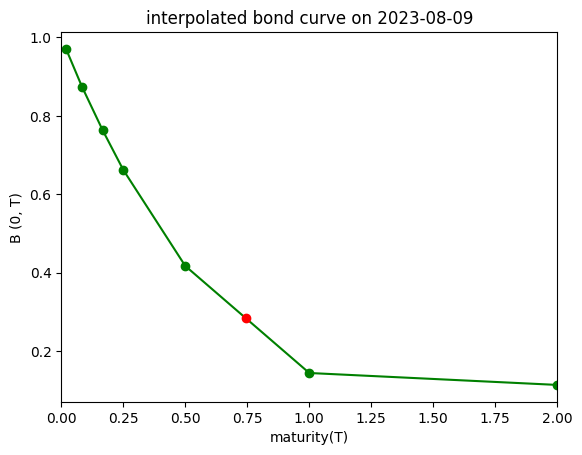

In [14]:
today = pd.Timestamp('2023-08-09')
date = pd.Timestamp('2023-11-01')

bond_table = pd.DataFrame(index=pd.date_range(today, cs.FINAL_FIXING_DATE), columns=['price'])
X = [get_period(col) for col in bond_price.columns]
Y = bond_price.loc[today].to_list()
tdelta = (cs.FINAL_FIXING_DATE - date).days/365
print(f'time difference is {tdelta*365}')
interpolated_y = np.interp(tdelta,X,Y)
plt.xlim((0,2))
plt.xlabel('maturity(T)')
plt.ylabel('B (0, T)')
plt.title('interpolated bond curve on {}'.format(today.strftime('%Y-%m-%d')))
plt.plot(X, Y, "og-", tdelta, interpolated_y, "or")

In [15]:
# Variance reduction
today = pd.Timestamp('2023-08-09')

# calculate means
s_01  = data.loc[today]['LONN.SW']
s_02 =  data.loc[today]['SIKA.SW']
mu1 = s_01 * np.exp(cs.INTEREST_RATE*(cs.FINAL_FIXING_DATE - today).days/252)
mu2 = s_02 * np.exp(cs.INTEREST_RATE*(cs.FINAL_FIXING_DATE  - today).days/252)
print(mu1, mu2)


501.23984130744617 272.1455580104846


In [16]:
sim_arr = product_est_date_sim_data_df_list[0]
S1T_n = []
S2T_n = []
for i in range(len(sim_arr)):
    sim_arr[i] = sim_arr[i].rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
    ST = sim_arr[i].iloc[-1,:]
    S1T_n.append(ST[cs.ASSET_NAMES[0]])
    S2T_n.append(ST[cs.ASSET_NAMES[1]])
payoffs = po.pricing_multiple(sim_arr)

In [17]:
payoffs_cv = apply_control_variates(S1T_n, S2T_n, mu1, mu2, payoffs)
payoffs_cv.var()

76802.20805773576

In [18]:
payoff = np.array(payoffs[50:])
payoff.var()

124691.59380385818

In [19]:
ptg_change = (payoff.var() - payoffs_cv.var())/payoff.var()
ptg_change

0.38406266441227127

In [51]:
data = data.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
sim_arr_EMC = apply_empirical_martingale_correction(data, sim_arr)

In [54]:
sim_arr_EMC[1]

,LONN.SE,SIKA.SE
Date,,
2023-08-10,512.152073,273.612768
2023-08-11,509.548825,270.441801
2023-08-14,500.239215,272.806712
2023-08-15,504.775348,274.733513
2023-08-16,519.960811,278.505085
...,...,...
2024-07-24,482.46873,256.994085
2024-07-25,496.352023,263.783649
2024-07-26,496.186385,269.613636


<Axes: title={'center': 'Empirical Martingale Correction'}, xlabel='Date'>

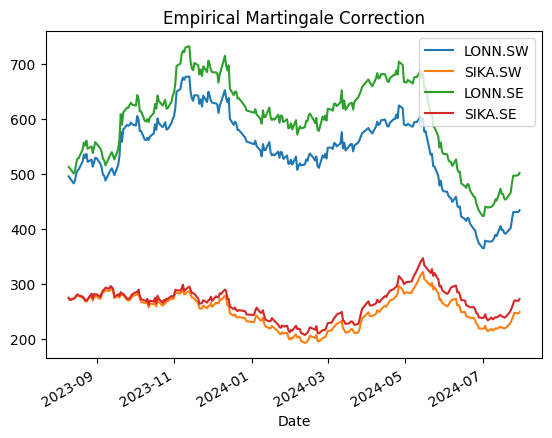

In [57]:
pd.concat([sim,sim_arr_EMC[1]],axis=1).plot(title='Empirical Martingale Correction')